<a href="https://colab.research.google.com/github/Franciutte/FastImageClassification/blob/master/Alpaca_images_generation_1_1_higher_frequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Installing dependencies

In [ ]:
!pip install alpaca-trade-api
!pip install mpl_finance


     |████████████████████████████████| 204kB 6.1MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 


setting up Alpaca API REST

In [ ]:
import alpaca_trade_api as alpaca

api = alpaca.REST('PK84TPIHHGPF5EXINPG6', 'qjZlsZZmR8Xsh8rWF5sE5ta5eh1diykAxJ2WZ075', 'https://paper-api.alpaca.markets')


imports

In [ ]:
import pandas as pd

from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

import datetime

from PIL import Image
from PIL import ImageChops
from PIL import ImageStat
from pylab import *
import random 

#for candlestick plots
import plotly.graph_objects as go

#for histograms of list of strings
from collections import Counter

#tensorFlow
import tensorflow as tf
import IPython.display as display

#Keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

#TQDM (progress bar)
from tqdm.notebook import trange, tqdm

google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#parameters

#size of the square pictures that will be analyzed with ML (for testing - the actual IMG_SIZE is defined in the main function)
IMG_SIZE = 80

# getting some account info

In [ ]:
api.get_account()
api.list_positions()

[Position({   'asset_class': 'us_equity',
     'asset_id': '3f3e0ff9-599f-4fec-8842-6bc53f5129a1',
     'avg_entry_price': '118.23',
     'change_today': '0.0019217976199276',
     'cost_basis': '945.84',
     'current_price': '135.55',
     'exchange': 'NYSE',
     'lastday_price': '135.29',
     'market_value': '1084.4',
     'qty': '8',
     'side': 'long',
     'symbol': 'WMT',
     'unrealized_intraday_pl': '2.08',
     'unrealized_intraday_plpc': '0.0019217976199276',
     'unrealized_pl': '138.56',
     'unrealized_plpc': '0.1464941216273365'}),
 Position({   'asset_class': 'us_equity',
     'asset_id': '58561d82-1557-43f5-9f84-5c722a37a056',
     'avg_entry_price': '38.43',
     'change_today': '0',
     'cost_basis': '845.46',
     'current_price': '36.17',
     'exchange': 'NYSE',
     'lastday_price': '36.17',
     'market_value': '795.74',
     'qty': '22',
     'side': 'long',
     'symbol': 'CNNE',
     'unrealized_intraday_pl': '0',
     'unrealized_intraday_plpc': '0',


# Getting data from Alpaca

getting list of Alpaca assets and info

In [ ]:
#getting list of Alpaca assets and info
listAssets = api.list_assets(status=None, asset_class=None)
dfAssets = pd.DataFrame(listAssets) 
print(len(listAssets), 'assets listed on Alpaca')

#filter to keep tradable assets
listAssetsTradable = [asset for asset in listAssets if asset.tradable]

assetSymbolListTradable = []
for i in range(len(listAssetsTradable)):
  try:
    assetSymbolListTradable.append(listAssetsTradable[i].symbol)
  except IndexError:
    print('list index out of range ' + str(assetNumber))

print(len(listAssetsTradable), 'tradable assets listed on Alpaca')
print(assetSymbolListTradable[0:400])

10099 assets listed on Alpaca
8830 tradable assets listed on Alpaca
['VTI', 'VUG', 'A', 'U', 'BIVI', 'AACG', 'AADR', 'AAMC', 'AAME', 'AAN', 'AAON', 'AAT', 'AAU', 'ACEL', 'ACES', 'ACEVU', 'ACGLO', 'ACH', 'ACHV', 'ACIA', 'ACIU', 'ACLS', 'ACMR', 'ACNB', 'ACND.U', 'ACP', 'ACRS', 'ACRX', 'ACSG', 'ACSI', 'ACST', 'ACT', 'ACTG', 'ACU', 'ACV', 'ACWF', 'ACWI', 'ACWV', 'ACWX', 'ACY', 'ADAP', 'ADBE', 'ADC', 'ADCT', 'ADES', 'ADFI', 'ADI', 'ADIL', 'ADM', 'ADMA', 'ADME', 'ADMP', 'ADMS', 'ADNT', 'ADP', 'ADPT', 'ADRE', 'ADRO', 'ADS', 'ADSK', 'ADSW', 'ADT', 'ADTN', 'ADTX', 'ADUS', 'ADVM', 'ADX', 'ADXN', 'ADXS', 'AE', 'AEB', 'AEE', 'AEF', 'AEFC', 'AEG', 'AEGN', 'AEHR', 'AEIS', 'AEL', 'AEL-A', 'AEL-B', 'AEMD', 'AEP', 'AEP-B', 'AEP-C', 'AERI', 'AES', 'AESE', 'AESR', 'AEY', 'AEYE', 'AEZS', 'AFB', 'AFC', 'AFG', 'AFGB', 'AFGC', 'AFGD', 'AFGH', 'AFI', 'AFIB', 'AFIF', 'AFIN', 'AFINP', 'AFK', 'AFL', 'AFLG', 'AFMC', 'AFMD', 'AFSM', 'AFT', 'AFTY', 'AFYA', 'AG', 'AGBA', 'AGBAR', 'AGBAU', 'AGCO', 'AGD', 'AGE', 'AGEN

function to filter tradable assets out of a list

In [ ]:
def filter_tradable_symbols(listSymbols):
#filter to keep tradable symbols
  #getting list of Alpaca assets and info
  listAssetsAlpaca = api.list_assets(status=None, asset_class=None)
  
  #filter to keep all Alpaca tradable assets
  listAssetsAlpacaTradable = [asset for asset in listAssetsAlpaca if asset.tradable]
  listSymbolsAlpacaTradable = []
  for i in range(len(listAssetsAlpacaTradable)):
    try:
      listSymbolsAlpacaTradable.append(listAssetsAlpacaTradable[i].symbol)
    except IndexError:
      print('list index out of range ' + str(assetNumber))
  
  #filter input listSymbols
  output_listSymbolsTradable = [symbol for symbol in listSymbolsAlpacaTradable if (symbol in listSymbols)]
  return output_listSymbolsTradable

#test function - should return all symbols but the first (BT) and the last (FLORIAN)
test_list_symbol = ['BT', 'MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'FLORIAN']
filtered_test_list_symbol = filter_tradable_symbols(test_list_symbol)
print(test_list_symbol)
print(filtered_test_list_symbol)

['BT', 'MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'FLORIAN']
['BIOC', 'CALB', 'CSCO', 'DELL', 'EA', 'KO', 'LTRPB', 'MSFT', 'NRGD', 'TSLA']


In [ ]:
def Timestamp_UTC_iso_to_zulu(timestamp_utc):
  #function to get the timestamp in Alpaca format (with Z at the end instead of +00:00)
  timestamp_iso = timestamp_utc.isoformat()
  value = str(timestamp_iso).replace('+00:00', 'Z')
  value = value.replace('+01:00', 'Z')
  if value[-1] != 'Z':
    value = value + 'Z'
  return value

#test function
end = pd.Timestamp(year = 2020,  month = 2, day = 1, hour = 1, minute = 00, second = 00, tz = 'Europe/London')
value1 = Timestamp_UTC_iso_to_zulu(end)
print(value1)

delta = 2 * pd.Timedelta('15 minutes')
end = end - delta
value2 = Timestamp_UTC_iso_to_zulu(end)
print(value2)

end_test = pd.Timestamp(year = 2020,  month = 4, day = 17, hour = 17, minute = 1, second = 00, tz = 'Europe/London')
print('original:', end_test, ', zulu:',Timestamp_UTC_iso_to_zulu(end_test))

end_test2 = pd.Timestamp(year = 2020,  month = 2, day = 13, hour = 17, minute = 1, second = 00, tz = 'Europe/London')
print('original:', end_test2, ', zulu:',Timestamp_UTC_iso_to_zulu(end_test2))

end_test3 = pd.Timestamp(year = 2020,  month = 4, day = 17, hour = 17, minute = 1, second = 00, tz = 'Etc/UCT')
print('original:', end_test3, ', zulu:',Timestamp_UTC_iso_to_zulu(end_test))

2020-02-01T01:00:00Z
2020-02-01T00:30:00Z
original: 2020-04-17 17:01:00+01:00 , zulu: 2020-04-17T17:01:00Z
original: 2020-02-13 17:01:00+00:00 , zulu: 2020-02-13T17:01:00Z
original: 2020-04-17 17:01:00+00:00 , zulu: 2020-04-17T17:01:00Z


In [ ]:
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit) 
#test
start = pd.to_datetime('2020-05-10')
end = pd.to_datetime('2020-05-11')
test_dates = random_datetimes_or_dates(start, end, out_format='datetime', n=1)
for date in test_dates: print(date)
for date in test_dates: print(Timestamp_UTC_iso_to_zulu(date))

2020-05-10 18:13:02
2020-05-10T18:13:02Z


function to check if market was open for a certain time stamp

In [ ]:
def market_was_open(time_to_test):
  #function to check if market was open for a certain time stamp
    #time needs to be defined using Timestamp_UTC_iso_to_zulu
  #print(type(timeZ))
  timeZ = Timestamp_UTC_iso_to_zulu(time_to_test)
  alapaca_barstet_not_received = True
  while alapaca_barstet_not_received:
    try:
      barset = api.get_barset('AAPL', '1Min', 1, end=timeZ)
      alapaca_barstet_not_received = False  
    except Exception as ex:
      print("exception while getting Alpaca barsets", str(ex))
      time.sleep(10) #wait a bit

  bars = barset['AAPL']
  #print(bars)

  check_time = bars[0].t
  #print('check_time',check_time)
  check_time_neutral_tz = check_time.tz_convert(None)
  #print('check_time_neutral_tz',check_time_neutral_tz)
  delta = time_to_test - check_time_neutral_tz
  #print('delta',delta)
  delta_min = delta.total_seconds() / 60
  #print('delta_min',delta_min)

  
  #checl time elapsed between last 1min candle and tested datetime
  if (delta_min < 2):
    market_open = True
  else:
    market_open = False
  return market_open

#test
start = pd.to_datetime('2020-04-20') #monday
end = pd.to_datetime('2020-04-26') #sunday
test_date = random_datetimes_or_dates(start, end, out_format='datetime', n=1)
print('test_date',test_date[0])

print(market_was_open(test_date[0]))


test_date 2020-04-24 12:52:54
False


function to get data from Alpaca and return it in Panda DataFrames

In [ ]:
def get_pandas_barset(symbols, timeframe, limit, start=None, end=None, after=None, until=None):
  #return an object with a key for each symbol and Panda Dataframes as the values
  #max 200 symbols
  #candle can be: minute, 1Min, 5Min, 15Min, day or 1D
  #end needs to be definded using pd.Timestamp --> wxample: pd.Timestamp(year = 2019,  month = 11, day = 21, hour = 10, minute = 10, second = 49, tz = 'US/Eastern')
    #print("end:",end)
    #print('type end:', type(end))
    #print('space in end:', (' ' in end))
    alapaca_barstet_not_received = True
    while alapaca_barstet_not_received:
      try:
        barset = api.get_barset(symbols, timeframe, limit, start=start, end=end, after=after, until=until)
        alapaca_barstet_not_received = False  
      except Exception as ex:
        print("exception while getting Alpaca barsets", str(ex))
        time.sleep(10) #wait a bit
    
    dataframes = {}
    
    for symbol in barset.keys():
        bars = barset[symbol]

        data = {'close': [bar.c for bar in bars],
                'high': [bar.h for bar in bars],
                'low': [bar.l for bar in bars],
                'open': [bar.o for bar in bars],
                'time': [bar.t for bar in bars],
                'volume': [bar.v for bar in bars]}
        
        dataframes[symbol] = pd.DataFrame(data)
    
    return dataframes

function to get Alpaca pandas for a list of assets



In [ ]:
def getAlpacaPandas(symbols, timeframe, limit, start=None, end=None, after=None, until=None):
  #get Alpaca Pandas
  #return an Dict with a key for each symbol and Pandas as the values
  #candle can be: minute, 1Min, 5Min, 15Min, day or 1D
  #end needs to be definded using Timestamp_UTC_iso_to_zulu
  
  #get Alpaca Pandas for tradable symbols
  quantityPerRequest = 200 #max barsets per request for Alpaca API
  chunks = [symbols[x:x+quantityPerRequest] for x in range(0, len(symbols), quantityPerRequest)]

  Dataframes = {}
  #print('%%% starting requests of', timeframe, 'dataframes %%%')
  for i in tqdm(range(len(chunks)), desc= ('downloading ' + timeframe + ' dataframes')):
    chunk = chunks[i]
    Dataframes.update(get_pandas_barset(chunk, timeframe, limit, start=start, end=end, after=after, until=until))
    #print(len(Dataframes), " dataframes received from Alpaca")
  #print('%%% end of', timeframe, 'dataframes downloading %%%','\n')
  return Dataframes

#test the function - 400 symbols
#testSymbols = ['MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'CFXA', 'MUS', 'EUO', 'DIA', 'IBTJ', 'BNKD', 'JVAL', 'IGIC', 'HKIB', 'KALV', 'UGAZ', 'FFBW', 'SBT', 'KIQ', 'ZKIN', 'JHME', 'BSCS', 'EAF', 'RDCM', 'EQM', 'LMPX', 'UIS', 'FIDI', 'FCNCA', 'VOO', 'IDXX', 'FTLS', 'MPX', 'BSCP', 'LND', 'AIA', 'ZEN', 'DDOG', 'ZM', 'PD', 'SBSW', 'QARP', 'PCTY', 'TEAM', 'ZVO', 'VZ', 'MBOT', 'SPUS', 'RPD', 'AYX', 'WDAY', 'CRM', 'SDC', 'SABR', 'I', 'ATUS', 'MU', 'SPOT', 'TWLO', 'GOOGL', 'SPCE', 'RGLD', 'NEM', 'INO', 'AAPL', 'FNV', 'KL', 'AU', 'BTG', 'EDOW', 'ECOW', 'JPME', 'FUMB', 'AVUV', 'PLC', 'HDIV', 'USAU', 'PEI', 'BLPH', 'CYH', 'PENN', 'RDFN', 'BYND', 'COST', 'GLD', 'IEX', 'LSXMB', 'LCA', 'DCUE', 'OPER', 'RFDA', 'IQIN', 'SPSK', 'EJUL', 'APRN', 'MEDS', 'PRPH', 'AMZN', 'UBER', 'SHOP', 'LULU', 'DAL', 'NWE', 'LYFT', 'BABA', 'BGCP', 'ENVA', 'TCS', 'FBNC', 'TBK', 'FIX', 'WHF', 'GAIA', 'CTAS', 'ALBO', 'DVD', 'SSB', 'MGI', 'COLL', 'NEE', 'EWP', 'FIVA', 'EWQ', 'EFNL', 'ECOM', 'SFBS', 'AGX', 'TWTR', 'GOOG', 'NCR', 'CEQP', 'SFL', 'GSX', 'ARDS', 'BWG', 'USDY', 'TCCO', 'GLMD', 'NIU', 'RESD', 'PEAK', 'CGW', 'PLW', 'CBB', 'IYC', 'HCAC', 'TLTD', 'FDX', 'PSC', 'DIG', 'MVIN', 'UEVM', 'MCY', 'FMAT', 'HGLB', 'PAUG', 'GULF', 'HMI', 'BDCY', 'KBLM', 'XSHQ', 'NXPI', 'CFG', 'DAUD', 'PBI', 'PRSP', 'CTT', 'RYJ', 'NEXT', 'CKPT', 'DDS', 'CAG', 'SLF', 'GLBY', 'ALNA', 'ARE', 'EDZ', 'ESRT', 'RFFC', 'CCEP', 'GVIP', 'CSTM', 'DHS', 'CARG', 'GDAT', 'ENFR', 'IIPR', 'PYPL', 'ADBE', 'FB', 'SQ', 'SNAP', 'WMT', 'BKYI', 'TOPS', 'AHPI', 'CMI', 'ALV', 'EWK', 'DFFN', 'VRTS', 'TDG', 'GBF', 'PAAS', 'FUT', 'BURG', 'ABR', 'C', 'XLP', 'XLF', 'XLI', 'XLRE', 'IBM', 'OAS', 'TU', 'ERF', 'FRA', 'OVBC', 'DHC', 'MEOH', 'INPX', 'BIMI', 'NIO', 'WAT', 'AGS', 'WORK', 'NVTA', 'CS', 'SBR', 'EPAM', 'XTH', 'MMI', 'ILMN', 'SPSC', 'LBTYB', 'TELL', 'ENS', 'HYD', 'HSKA', 'MN', 'KRA', 'SYX', 'RPAI', 'GDL', 'THS', 'EIG', 'DRR', 'SGOL', 'MDWD', 'AVNW', 'PTI', 'ADM', 'PNOV', 'SHEN', 'LPTX', 'ERC', 'SPT', 'CELH', 'DVN', 'MVIS', 'FTCS', 'FFTG', 'ILF', 'MOTO', 'MGEE', 'CSWI', 'FIXD', 'PIC', 'UBS', 'STX', 'TBT', 'MCMJ', 'VTI', 'TTOO', 'NUGT', 'CNCR', 'CODX', 'TDOC', 'ONEM', 'CRAI', 'SPWH', 'SDPI', 'KREF', 'NFBK', 'VXX', 'SPY', 'YINN', 'APTV', 'GNCA', 'GEVO', 'MFH', 'CMC', 'MUDS', 'GHYG', 'GAM', 'CCL', 'XES', 'XOP', 'APVO', 'MEXX', 'LBJ', 'RFM', 'DOW', 'A', 'ZTS', 'BMY', 'HTBX', 'DUST', 'PHO', 'INSUU', 'JHMD', 'TOTA', 'SMMCU', 'NJAN', 'DVLU', 'KNAB', 'MMIT', 'FSRVU', 'SSPK', 'PGM', 'THCA', 'AE', 'LMT', 'MS-L', 'SBLKZ', 'FMS', 'UZC', 'IHY', 'KODK', 'AI-B', 'BA', 'PFLD', 'AEFC', 'STAG-C', 'GDXJ', 'FVCB', 'IBKCN', 'SIVBP', 'MAYS', 'INSI', 'RODM', 'UVXY', 'CID', 'EMSG', 'CHMI-B', 'BRG-D', 'MDLQ', 'CHSCN', 'CHSCO', 'GUT-A', 'AIRTP', 'RZB', 'VLYPP', 'FTXD', 'BBD', 'RILYN', 'NET', 'ANDAR', 'VOX', 'PSCC', 'LKOR', 'CEIX', 'NUSI', 'QVCC', 'PYS', 'SHYG', 'SRG-A', 'KSCD', 'ONCY', 'GYRO', 'MSA', 'AHL-E', 'DBA', 'WHLRD', 'TCO-K', 'BCOV', 'BSMT', 'PMT-A', 'VRCA', 'DGAZ', 'PTNR', 'MBII', 'BIS', 'FVC', 'FPX', 'BPMX', 'FUD', 'IDYA', 'MIDD', 'HESM', 'EVH', 'DAVA', 'ATGE', 'HMN', 'MSBI']
testSymbols = ['BT', 'MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'FLORIAN']
testPandas = getAlpacaPandas(testSymbols, '1D', IMG_SIZE, end = Timestamp_UTC_iso_to_zulu(pd.Timestamp(year = 2020,  month = 2, day = 1, hour = 1, minute = 00, second = 00, tz = 'Europe/London')))

function to add rows to pandas too short compared to expected number of rows (typically less rows than expected image size). It is done by copying the first line over and over

In [ ]:
def filling_short_pandas_to_sizeImage(panda, sizeImage):
  #function to add rows to pandas too short compared to expected number of rows (typically less rows than expected image size). 
  #--> It is done by copying the first line over and over
  missing_frames = sizeImage - len(panda)
  #create a NaN panda of the right size to fill input panda
  index_NaN_panda = [*range(0, missing_frames, 1)] 
  NaN_panda = pd.DataFrame(np.nan, index_NaN_panda, columns=list(panda))
  #concatenate pandas
  filledPanda = pd.concat([NaN_panda,panda], ignore_index=True)
  #replace NaN values by the values of the first row of input panda
  filledPanda = filledPanda.fillna(method ='bfill') 
  return filledPanda

#test function
pandaRandomTest = pd.DataFrame(np.random.randint(0,100,size=(15, 6)), columns=list('ohlcvV'))
print(pandaRandomTest)
filledPandaRandomTest = filling_short_pandas_to_sizeImage(pandaRandomTest,IMG_SIZE)
print(filledPandaRandomTest)



     o   h   l   c   v   V
0   43  36  15  18  53  63
1   90  45  43  42  94   0
2   68  43   7  44  46  73
3   75   4  79  25  49  66
4   91  46  18  24  50  93
5   91  64  12  80  99  58
6   12  87  84  75  62  38
7   17  89  26  28   0  10
8   25  50  14  86  12  65
9   71  57  78  43  21   8
10  95  35  95  49  22  68
11  70  32  36  60  37   4
12  45  96  18  99  12  77
13  68  30  95  54  96  60
14  68  93  57  50   5  57
       o     h     l     c     v     V
0   43.0  36.0  15.0  18.0  53.0  63.0
1   43.0  36.0  15.0  18.0  53.0  63.0
2   43.0  36.0  15.0  18.0  53.0  63.0
3   43.0  36.0  15.0  18.0  53.0  63.0
4   43.0  36.0  15.0  18.0  53.0  63.0
..   ...   ...   ...   ...   ...   ...
75  95.0  35.0  95.0  49.0  22.0  68.0
76  70.0  32.0  36.0  60.0  37.0   4.0
77  45.0  96.0  18.0  99.0  12.0  77.0
78  68.0  30.0  95.0  54.0  96.0  60.0
79  68.0  93.0  57.0  50.0   5.0  57.0

[80 rows x 6 columns]


# data preprocessing

data preprocessing functions: normalize open, high, low and close together, normalize volume apart + add a row with variation in % between open and close

In [ ]:
def panda_ohlcv_normalize(dataset):
  #normalize a panda: open, high, low and close together, normalize volume apart - on a 0-1 scale
  try:
    dataOhlc = dataset[["open","high","low","close"]]
    #dataOhlc = dataOhlc.drop('time', axis=1)
    dataOhlcNorm =((dataOhlc-dataOhlc.min())/(dataOhlc.max()-dataOhlc.min())) *1
    dataNorm = dataset
    dataNorm["open"] = dataOhlcNorm ["open"]
    dataNorm["high"] = dataOhlcNorm ["high"]
    dataNorm["low"] = dataOhlcNorm ["low"]
    dataNorm["close"] = dataOhlcNorm ["close"]
    #normalize volume
    dataNorm["volume"]= ((dataNorm["volume"]-dataNorm["volume"].min())/(dataNorm["volume"].max()-dataNorm["volume"].min()))*1
    return dataNorm
  except AttributeError:
    print('dataset is empty')

def panda_ohlcv_preprocess(panda):
  #preprocess = normalize ohlcv+ %variation panda + add a variation column + convert panda from float to int
  panda["variation"] = (panda["close"]-panda["open"])/panda["open"] 
  panda.loc[panda["variation"] > 1, "variation"] = 1 #all variations > +100% are ceiled to 100%
  panda["variation"] = panda["variation"] * 1 #variation from -100% to +100% --> negative values will be converted in red, positive in blue in rgb array
  panda = panda_ohlcv_normalize(panda)
  #pandaInt=panda.astype(int)
  #pandaInt["time"] = panda['time']
  return panda

#test functions
dataToNormalizeKey = random.choice(list(testPandas))
dataToNormalize = testPandas[dataToNormalizeKey]
print(dataToNormalize.describe())
print(dataToNormalize)
datadfNorm = panda_ohlcv_preprocess(dataToNormalize)
print(datadfNorm.describe())
print(datadfNorm)

           close       high        low       open        volume
count  80.000000  80.000000  80.000000  80.000000  8.000000e+01
mean    0.497596   0.521259   0.481577   0.503212  4.417702e+06
std     0.199828   0.204453   0.198361   0.202925  7.503780e+06
min     0.238100   0.245000   0.227500   0.239500  1.024650e+05
25%     0.310400   0.327475   0.300000   0.310000  3.272615e+05
50%     0.520525   0.544450   0.510950   0.531200  1.332154e+06
75%     0.705725   0.736025   0.675000   0.703250  5.378481e+06
max     0.800000   0.820000   0.789500   0.820000  4.307181e+07
       close    high     low    open                      time   volume
0   0.796800  0.8200  0.7800  0.8200 2019-10-08 00:00:00-04:00   529167
1   0.793100  0.8011  0.7895  0.7983 2019-10-09 00:00:00-04:00   271722
2   0.781600  0.8100  0.7800  0.8100 2019-10-10 00:00:00-04:00   320216
3   0.800000  0.8000  0.7700  0.7986 2019-10-11 00:00:00-04:00   311393
4   0.763300  0.7976  0.7000  0.7976 2019-10-14 00:00:00-04:00  

# get data for a unique timeframe, assess the status with various "futur offsets"

for each symbol, in a dict of dicts, we want:

* symbol, end date, length futur
* data (ohlcv + variation) for each timeframe, with as many candles as the size of the square pictures that will be analyzed with ML
* the status after 15 minutes, 1h, 2h, 12h, 24h, 48h --> it will be used as labels for training
* the 15 minutes panda including the "futur", for visual verification

We don't want to get data when market is close




In [ ]:

minimum_daily_volume = 1000000 #in $, to be adapted

def get_pandas_for_tradable_assets_images(symbols, end, candle_duration):
  #end needs to be definded using pd.Timestamp --> wxample: pd.Timestamp(year = 2019,  month = 11, day = 21, hour = 10, minute = 10, second = 49, tz = 'Europe/London')
  #end must be at last 48h old (which is the "futur" used to define the status --> labels)
  
  #filter tradable symbols to avoid errors
  tradableSymbols = filter_tradable_symbols(symbols)
  print(len(tradableSymbols),'tradable symbols filtered out of', len(symbols), '\n')

  #format end timestamp with Z at the end (mandatory for Alpaca)
  end_zulu = Timestamp_UTC_iso_to_zulu(end)
  print('end datetime',end, 'zulu end datetime', end_zulu,'\n')

  #get 1000 candles
  data_present_and_future = getAlpacaPandas(tradableSymbols, candle_duration, 1000, until = end_zulu)
  
  #filter and delete symbols with empty or too short pandas, to avoid later bugs
  original_number_pandas = len(data_present_and_future)
  list_symbols_to_delete = []
  for symbol in data_present_and_future:
    if (data_present_and_future[symbol].empty or len(data_present_and_future[symbol])<1000):
      #print('at least one empty panda for', symbol, '--> all pandas must be deleted for that symbol.')
      list_symbols_to_delete.append(symbol)

  for symbol in list_symbols_to_delete:
    del data_present_and_future[symbol]  

  number_deleted_pandas = original_number_pandas - len(data_present_and_future)
  print(number_deleted_pandas, 'symbols have been deleted out of', original_number_pandas, 'because of empty or too short panda, for', list_symbols_to_delete)
  print('number of remaining symbols pandas:', len(data_present_and_future),'\n')

  remainingSymbols = []
  for symbol in data_present_and_future:
    remainingSymbols.append(symbol)
  
  
  #merge present and future pandas
  data_present={}
  data_future={}
  for symbol in data_present_and_future:
    data_present[symbol]= data_present_and_future[symbol].iloc[:500]
    data_future[symbol]= data_present_and_future[symbol].iloc[500:]

  #summarize number of rows for each symbol, for info
  rows_per_panda = {'Symbol':  [symbol for symbol in  data_present],
      'data_present': [len(data_present[symbol]) for symbol in  data_present],
      'data_future': [len(data_future[symbol]) for symbol in  data_present]
      }
  df_rows_per_panda = pd.DataFrame (rows_per_panda, columns = ['Symbol','data_present','data_future'])
  #print(df_rows_per_panda.describe(),'\n')

  #create empty return dictionary
  return_dict = {}

  for symbol in data_present:
    symbol_dict = {
        'symbol' : symbol,
        'end timestamp' : end,
        'end timestamp_zulu' : end_zulu,
        'panda_present' : data_present[symbol],
        'panda_present_first_candle' : data_present[symbol]['time'].iloc[0],
        'panda_present_last_candle' : data_present[symbol]['time'].iloc[-1],
        'panda_present_last_close' : data_present[symbol]['close'].iloc[-1],
        'panda_future' : data_future[symbol],
        'panda_future_first_candle' : data_future[symbol]['time'].iloc[0],
        'panda_future_last_candle' : data_future[symbol]['time'].iloc[-1],
        'panda_present_and_future' : data_present_and_future[symbol],
        'panda_present_and_future_first_candle' : data_present_and_future[symbol]['time'].iloc[0],
        'panda_present_and_future_last_candle' : data_present_and_future[symbol]['time'].iloc[-1]
      }

    return_dict[symbol] = symbol_dict
  #print(return_dict)
  
  random_symbol = random.choice(list(return_dict.keys()))
  random_symbol_dict = return_dict[random_symbol]
  print(random_symbol_dict['symbol'])

  #print(random_symbol_dict['panda_present'])
  #print(random_symbol_dict['panda_future'])
  #print(random_symbol_dict['panda_present_and_future'])
  
  
  #check actual end datetime from data
  print('check some dates:')
  print('original end datetime:',end)
  print('panda_present: last candle', random_symbol_dict['panda_present_last_candle'])
  print('panda_future: first candle', random_symbol_dict['panda_future_first_candle'],'\n')
  return return_dict


#test the function - several symbols, but the 2 first are not tradable ('BT','FLORIAN')
testSymbols = ['BT','FLORIAN', 'SPY', 'CCL', 'TSLA', 'GEVO', 'GRMN', 'CTR', 'CNCR', 'CODX', 'CPE']
#testSymbols = ['TSLA']

#testSymbols = ['BT','FLORIAN','MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'CFXA', 'MUS', 'EUO', 'DIA', 'IBTJ', 'BNKD', 'JVAL', 'IGIC', 'HKIB', 'KALV', 'UGAZ', 'FFBW', 'SBT', 'KIQ', 'ZKIN', 'JHME', 'BSCS', 'EAF', 'RDCM', 'EQM', 'LMPX', 'UIS', 'FIDI', 'FCNCA', 'VOO', 'IDXX', 'FTLS', 'MPX', 'BSCP', 'LND', 'AIA', 'ZEN', 'DDOG', 'ZM', 'PD', 'SBSW', 'QARP', 'PCTY', 'TEAM', 'ZVO', 'VZ', 'MBOT', 'SPUS', 'RPD', 'AYX', 'WDAY', 'CRM', 'SDC', 'SABR', 'I', 'ATUS', 'MU', 'SPOT', 'TWLO', 'GOOGL', 'SPCE', 'RGLD', 'NEM', 'INO', 'AAPL', 'FNV', 'KL', 'AU', 'BTG', 'EDOW', 'ECOW', 'JPME', 'FUMB', 'AVUV', 'PLC', 'HDIV', 'USAU', 'PEI', 'BLPH', 'CYH', 'PENN', 'RDFN', 'BYND', 'COST', 'GLD', 'IEX', 'LSXMB', 'LCA', 'DCUE', 'OPER', 'RFDA', 'IQIN', 'SPSK', 'EJUL', 'APRN', 'MEDS', 'PRPH', 'AMZN', 'UBER', 'SHOP', 'LULU', 'DAL', 'NWE', 'LYFT', 'BABA', 'BGCP', 'ENVA', 'TCS', 'FBNC', 'TBK', 'FIX', 'WHF', 'GAIA', 'CTAS', 'ALBO', 'DVD', 'SSB', 'MGI', 'COLL', 'NEE', 'EWP', 'FIVA', 'EWQ', 'EFNL', 'ECOM', 'SFBS', 'AGX', 'TWTR', 'GOOG', 'NCR', 'CEQP', 'SFL', 'GSX', 'ARDS', 'BWG', 'USDY', 'TCCO', 'GLMD', 'NIU', 'RESD', 'PEAK', 'CGW', 'PLW', 'CBB', 'IYC', 'HCAC', 'TLTD', 'FDX', 'PSC', 'DIG', 'MVIN', 'UEVM', 'MCY', 'FMAT', 'HGLB', 'PAUG', 'GULF', 'HMI', 'BDCY', 'KBLM', 'XSHQ', 'NXPI', 'CFG', 'DAUD', 'PBI', 'PRSP', 'CTT', 'RYJ', 'NEXT', 'CKPT', 'DDS', 'CAG', 'SLF', 'GLBY', 'ALNA', 'ARE', 'EDZ', 'ESRT', 'RFFC', 'CCEP', 'GVIP', 'CSTM', 'DHS', 'CARG', 'GDAT', 'ENFR', 'IIPR', 'PYPL', 'ADBE', 'FB', 'SQ', 'SNAP', 'WMT', 'BKYI', 'TOPS', 'AHPI', 'CMI', 'ALV', 'EWK', 'DFFN', 'VRTS', 'TDG', 'GBF', 'PAAS', 'FUT', 'BURG', 'ABR', 'C', 'XLP', 'XLF', 'XLI', 'XLRE', 'IBM', 'OAS', 'TU', 'ERF', 'FRA', 'OVBC', 'DHC', 'MEOH', 'INPX', 'BIMI', 'NIO', 'WAT', 'AGS', 'WORK', 'NVTA', 'CS', 'SBR', 'EPAM', 'XTH', 'MMI', 'ILMN', 'SPSC', 'LBTYB', 'TELL', 'ENS', 'HYD', 'HSKA', 'MN', 'KRA', 'SYX', 'RPAI', 'GDL', 'THS', 'EIG', 'DRR', 'SGOL', 'MDWD', 'AVNW', 'PTI', 'ADM', 'PNOV', 'SHEN', 'LPTX', 'ERC', 'SPT', 'CELH', 'DVN', 'MVIS', 'FTCS', 'FFTG', 'ILF', 'MOTO', 'MGEE', 'CSWI', 'FIXD', 'PIC', 'UBS', 'STX', 'TBT', 'MCMJ', 'VTI', 'TTOO', 'NUGT', 'CNCR', 'CODX', 'TDOC', 'ONEM', 'CRAI', 'SPWH', 'SDPI', 'KREF', 'NFBK', 'VXX', 'SPY', 'YINN', 'APTV', 'GNCA', 'GEVO', 'MFH', 'CMC', 'MUDS', 'GHYG', 'GAM', 'CCL', 'XES', 'XOP', 'APVO', 'MEXX', 'LBJ', 'RFM', 'DOW', 'A', 'ZTS', 'BMY', 'HTBX', 'DUST', 'PHO', 'INSUU', 'JHMD', 'TOTA', 'SMMCU', 'NJAN', 'DVLU', 'KNAB', 'MMIT', 'FSRVU', 'SSPK', 'PGM', 'THCA', 'AE', 'LMT', 'MS-L', 'SBLKZ', 'FMS', 'UZC', 'IHY', 'KODK', 'AI-B', 'BA', 'PFLD', 'AEFC', 'STAG-C', 'GDXJ', 'FVCB', 'IBKCN', 'SIVBP', 'MAYS', 'INSI', 'RODM', 'UVXY', 'CID', 'EMSG', 'CHMI-B', 'BRG-D', 'MDLQ', 'CHSCN', 'CHSCO', 'GUT-A', 'AIRTP', 'RZB', 'VLYPP', 'FTXD', 'BBD', 'RILYN', 'NET', 'ANDAR', 'VOX', 'PSCC', 'LKOR', 'CEIX', 'NUSI', 'QVCC', 'PYS', 'SHYG', 'SRG-A', 'KSCD', 'ONCY', 'GYRO', 'MSA', 'AHL-E', 'DBA', 'WHLRD', 'TCO-K', 'BCOV', 'BSMT', 'PMT-A', 'VRCA', 'DGAZ', 'PTNR', 'MBII', 'BIS', 'FVC', 'FPX', 'BPMX', 'FUD', 'IDYA', 'MIDD', 'HESM', 'EVH', 'DAVA', 'ATGE', 'HMN', 'MSBI']
test_dict = get_pandas_for_tradable_assets_images(testSymbols, pd.Timestamp(year = 2020,  month = 3, day = 12, hour = 15, minute = 57, second = 49, tz = 'Europe/London'), '5Min')


9 tradable symbols filtered out of 11 

end datetime 2020-03-12 15:57:49+00:00 zulu end datetime 2020-03-12T15:57:49Z 




0 symbols have been deleted out of 9 because of empty or too short panda, for []
number of remaining symbols pandas: 9 

CCL
check some dates:
original end datetime: 2020-03-12 15:57:49+00:00
panda_present: last candle 2020-03-04 11:05:00-05:00
panda_future: first candle 2020-03-04 11:10:00-05:00 



# generate image from data



In [ ]:
def display_one_image(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  plt.show
  

def display_nine_images(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_image(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

tf.Tensor([80 80  3], shape=(3,), dtype=int32)
CNCR


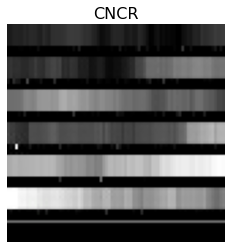

In [ ]:
def generatePandasImage(size_images,panda):
  #generate jpeg square images from a list of pandas with 1 unique timeframes (i.e. 5min) + (optional) some context data at the bottom (hour to start, maybe major indices later)
  
  #save some lines at the bottom for context info
  context_bottom_lines = 1

  #preprocess the panda
  dataToPreprocess = panda.copy()
  dataPandaNorm = panda_ohlcv_preprocess(dataToPreprocess)

  #define number of repetition of each line of each panda (to get a square image)
  #panda provided contains a certain number of candles (usually 1000, which is Alpaca API max per request)
  number_candles = len(dataPandaNorm)
  #define number of stripes = number_candles // size_images
  number_stripes = number_candles // size_images
  #divide panda into a list of pandas, 1 panda per stripe
  list_pandas = []
  for i in range(number_stripes):
    list_pandas.append(dataPandaNorm[i*size_images:(i+1)*size_images])
  #print(list_pandas)
  
  #divide size_images by 6 * number of stipes-pandas (6 for open, high, low, close, volume, variation) - keep int = number of repetition of each line to get an approximately square array / image
  repetitions = (size_images - context_bottom_lines) // (6 * len(list_pandas)) #-context_bottom_lines to keep some lines at botton for context info
  #print(size_images, len(list_pandas), repetitions)
  missing_lines = (size_images - context_bottom_lines) % (6 * len(list_pandas)) + context_bottom_lines #missing lines = remainder of division + context_bottom_lines

  #check if all pandas have the same size
  error_len_pandas = False
  for panda in list_pandas:
    if len(panda) != size_images:
      error_len_pandas = True
  if error_len_pandas:
    print('error: some pandas have different sizes', )
  
  #create empty array with the right size
  dfSquareArrayRGB = np.array([]).reshape(0,size_images,3) #3 for RGB array

  #preprocess each panda and add it as a stripe to final asset-array-image
  for panda in list_pandas:
    #convert panda colums to horizontal arrays
    openArray = panda['open'].to_numpy().T
    closeArray = panda['close'].to_numpy().T
    highArray = panda['high'].to_numpy().T
    lowArray = panda['low'].to_numpy().T
    volumeArray = panda['volume'].to_numpy().T
    #dissociate variation array into positive variation array and negative variation array
    variationArray = panda['variation'].to_numpy().T
    variationArrayPositive = variationArray.copy()
    variationArrayPositive[variationArrayPositive<0] = 0
    variationArrayNegative = variationArray.copy()
    variationArrayNegative[variationArrayNegative > 0] = 0
    variationArrayNegative = np.negative(variationArrayNegative)

    #print('max variationArrayPositive', max(variationArrayPositive))
    #print('max variationArrayNegative', max(variationArrayNegative))

    #extend arrays into strips based on image size and number of pandas
    openArrayStrip = array([openArray,]*repetitions)
    closeArrayStrip = array([closeArray,]*repetitions)
    highArrayStrip = array([highArray,]*repetitions)
    lowArrayStrip = array([lowArray,]*repetitions)
    volumeArrayStrip = array([volumeArray,]*repetitions)
    variationArrayPositiveStrip = array([variationArrayPositive,]*repetitions)
    variationArrayNegativeStrip = array([variationArrayNegative,]*repetitions)

    #create RGB arrayStips - ohclv in gray, variation in green for + and red for -
    zerosArrayStrip = np.zeros((repetitions, size_images))
    
    openArrayStripRGB = array([openArrayStrip,openArrayStrip,openArrayStrip]).transpose((1,2,0))
    closeArrayStripRGB = array([closeArrayStrip,closeArrayStrip,closeArrayStrip]).transpose((1,2,0))
    highArrayStripRGB = array([highArrayStrip,highArrayStrip,highArrayStrip]).transpose((1,2,0))
    lowArrayStripRGB = array([lowArrayStrip,lowArrayStrip,lowArrayStrip]).transpose((1,2,0))
    volumeArrayStripRGB = array([volumeArrayStrip,volumeArrayStrip,volumeArrayStrip]).transpose((1,2,0))
    variationArrayStripRGB = array([variationArrayNegativeStrip, variationArrayPositiveStrip,zerosArrayStrip]).transpose((1,2,0))
    #concatenate ohlcv+V strips for this frame
    dfStripeArrayRGB=concatenate((openArrayStripRGB,closeArrayStripRGB,highArrayStripRGB,lowArrayStripRGB,volumeArrayStripRGB,variationArrayStripRGB))
    #adding this frame stripe to final square array-image
    dfSquareArrayRGB = concatenate((dfSquareArrayRGB,dfStripeArrayRGB))
    #print(dfSquareArrayRGB.shape)
  
  #add missing lines with context info at the bottom
  lastStripRGB = np.zeros((missing_lines,size_images,3))
  end_timestamp = list_pandas[0]['time'].iloc[-1]
  end_time = end_timestamp.time()
  end_time_minute = end_time.hour * 60 + end_time.minute
  color_code = end_time_minute / 1440 #1440 minutes / day
  lastStripRGB[0]=color_code #seems to reduce accuracy during training...
  #print(end_timestamp,end_time,end_time_minute) 
  dfSquareArrayRGB=concatenate((dfSquareArrayRGB,lastStripRGB))
  #print(dfSquareArrayRGB.shape)

  #convert to an 0-255 int array
  dfSquareArrayRGB_0_255_int = dfSquareArrayRGB.copy()
  dfSquareArrayRGB_0_255_int = 255* dfSquareArrayRGB_0_255_int
  dfSquareArrayRGB_0_255_int = dfSquareArrayRGB_0_255_int.astype(int)

  #convert to image with PIL
  image_pil = array_to_img(dfSquareArrayRGB)

  #convert to jpeg image with tf
  #use tuto https://medium.com/@Joocheol_Kim/input-pipeline-and-tfrecord-1fc111a02790
  image_tf = tf.io.encode_jpeg(dfSquareArrayRGB_0_255_int, quality=100, chroma_downsampling=False)

  return image_tf



#test function
random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
panda = random_symbol_dict['panda_present']
test_image = generatePandasImage(IMG_SIZE,panda)
print(tf.io.extract_jpeg_shape(test_image))
print(random_symbol)
#print('max test_image', np.amax(test_image))
decoded_from_jpeg = tf.io.decode_jpeg(test_image)
display_one_image(decoded_from_jpeg,random_symbol_dict['symbol'],111,'black')







function to plot candlestick chart with a delimitation showing when "future" starts



In [ ]:
def plot_candlestick_chart_with_future(df,symbol,end,end_future,df_last_close, stoploss_percentage, takeprofit_percentage):
  #function to plot candlestick chart with a delimitation showing when "future" starts
  stoploss = df_last_close * (1+stoploss_percentage/100)
  takeprofit = df_last_close * (1+takeprofit_percentage/100)
  fig = go.Figure(data=[go.Candlestick(x=df['time'],
                open=df['open'], high=df['high'],
                low=df['low'], close=df['close'])
                      ])
  fig.update_layout(
    title=str(end) + ' - ' + symbol,
    yaxis_title=symbol,
    shapes = [dict(x0=end, x1=end, y0=0, y1=1, xref='x', yref='paper', line_width=0.5),
        dict(x0=end, x1=end_future, y0=df_last_close, y1=df_last_close, xref='x', yref='y',line_width=0.5),
        dict(x0=end, x1=end_future, y0=stoploss, y1=stoploss, xref='x', yref='y',line_width=0.5),
        dict(x0=end, x1=end_future, y0=takeprofit, y1=takeprofit, xref='x', yref='y',line_width=0.5)],
    annotations=[dict(
        x=end, y=0.05, xref='x', yref='paper',
        showarrow=False, xanchor='left', text='past / future limit')]
  )
  fig.show()

#test function
random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]

print(random_symbol_dict['panda_present_and_future'])

plot_candlestick_chart_with_future(random_symbol_dict['panda_present_and_future'],random_symbol_dict['symbol'],random_symbol_dict['panda_present_last_candle'],random_symbol_dict['panda_present_and_future_last_candle'],random_symbol_dict['panda_present_last_close'],-1,1)

plot_candlestick_chart_with_future(random_symbol_dict['panda_future'],random_symbol_dict['symbol'],random_symbol_dict['panda_present_last_candle'],random_symbol_dict['panda_present_and_future_last_candle'],random_symbol_dict['panda_present_last_close'],-1,1)

     close   high    low   open                      time  volume
0    8.920  8.920  8.920  8.920 2020-01-13 09:55:00-05:00     137
1    8.930  8.930  8.930  8.930 2020-01-13 10:05:00-05:00     258
2    8.950  8.950  8.950  8.950 2020-01-13 10:50:00-05:00     301
3    8.990  8.990  8.990  8.990 2020-01-13 11:10:00-05:00     100
4    9.000  9.000  9.000  9.000 2020-01-13 11:15:00-05:00     600
..     ...    ...    ...    ...                       ...     ...
995  2.510  2.510  2.510  2.510 2020-03-12 10:55:00-04:00     500
996  2.510  2.510  2.510  2.510 2020-03-12 11:00:00-04:00     400
997  2.515  2.515  2.510  2.510 2020-03-12 11:10:00-04:00     314
998  2.505  2.505  2.505  2.505 2020-03-12 11:15:00-04:00     100
999  2.490  2.490  2.490  2.490 2020-03-12 11:30:00-04:00     100

[1000 rows x 6 columns]


labelling function based on "future candles"



In [ ]:
def labelling_based_on_future_candles(symbol_dict, stoploss_percentage, takeprofit_percentage):
  #labelling function based on "future candles"
  #logic used: check what happens between last candles and considered "future" timeframe (number_future_candles_for_labelling)
  
  close_price = symbol_dict['panda_present_last_close']
  stoploss_price = close_price * (1 + stoploss_percentage/100)
  takeprofit_price = close_price * (1 + takeprofit_percentage/100)
  #print('close_price',close_price)
  #print('stoploss_price', stoploss_price)

  future_panda = symbol_dict['panda_future']

  #labelling:
  label = 'other'

  for candle, row in future_panda.iterrows():
    if row["low"] <= stoploss_price:
      label = 'short'
      break
    elif row["high"] >= takeprofit_price:
      label = 'long'
      break

  return label


#test function
stoploss_p = -1
takeprofit_p = 1
random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
label = labelling_based_on_future_candles(random_symbol_dict,stoploss_p,takeprofit_p)
print(label)
plot_candlestick_chart_with_future(random_symbol_dict['panda_future'],random_symbol_dict['symbol'],random_symbol_dict['panda_present_last_candle'],random_symbol_dict['panda_present_and_future_last_candle'],random_symbol_dict['panda_present_last_close'],stoploss_p,takeprofit_p)

long


adding image and labels to data

In [ ]:
def get_pandas_images_data_for_tradable_assets_images(size_images, symbols, end, candle_duration):
  return_dict_of_dicts = get_pandas_for_tradable_assets_images(symbols, end, candle_duration)
  
  print('starting image and labelling generation','\n')
  for symbol in return_dict_of_dicts:
    symbol_dict = return_dict_of_dicts[symbol]
    #generate and store image
    panda_symbol = symbol_dict['panda_present']
    symbol_image = generatePandasImage(size_images, panda_symbol)
    symbol_dict['image'] = symbol_image
    
    #generate and store labels
    stoploss_percentage = -1
    takeprofit_percentage = 1
    symbol_dict['label'] = labelling_based_on_future_candles(symbol_dict, stoploss_percentage, takeprofit_percentage)

  print('image and labelling generation done','\n')
  return return_dict_of_dicts


#test the function - several symbols, but the 2 first are not tradable ('BT','FLORIAN')
#testSymbols = ['BT','FLORIAN','MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD', 'CALB', 'LTRPB', 'CFXA', 'MUS', 'EUO', 'DIA', 'IBTJ', 'BNKD', 'JVAL', 'IGIC', 'HKIB', 'KALV', 'UGAZ', 'FFBW', 'SBT', 'KIQ', 'ZKIN', 'JHME', 'BSCS', 'EAF', 'RDCM', 'EQM', 'LMPX', 'UIS', 'FIDI', 'FCNCA', 'VOO', 'IDXX', 'FTLS', 'MPX', 'BSCP', 'LND', 'AIA', 'ZEN', 'DDOG', 'ZM', 'PD', 'SBSW', 'QARP', 'PCTY', 'TEAM', 'ZVO', 'VZ', 'MBOT', 'SPUS', 'RPD', 'AYX', 'WDAY', 'CRM', 'SDC', 'SABR', 'I', 'ATUS', 'MU', 'SPOT', 'TWLO', 'GOOGL', 'SPCE', 'RGLD', 'NEM', 'INO', 'AAPL', 'FNV', 'KL', 'AU', 'BTG', 'EDOW', 'ECOW', 'JPME', 'FUMB', 'AVUV', 'PLC', 'HDIV', 'USAU', 'PEI', 'BLPH', 'CYH', 'PENN', 'RDFN', 'BYND', 'COST', 'GLD', 'IEX', 'LSXMB', 'LCA', 'DCUE', 'OPER', 'RFDA', 'IQIN', 'SPSK', 'EJUL', 'APRN', 'MEDS', 'PRPH', 'AMZN', 'UBER', 'SHOP', 'LULU', 'DAL', 'NWE', 'LYFT', 'BABA', 'BGCP', 'ENVA', 'TCS', 'FBNC', 'TBK', 'FIX', 'WHF', 'GAIA', 'CTAS', 'ALBO', 'DVD', 'SSB', 'MGI', 'COLL', 'NEE', 'EWP', 'FIVA', 'EWQ', 'EFNL', 'ECOM', 'SFBS', 'AGX', 'TWTR', 'GOOG', 'NCR', 'CEQP', 'SFL', 'GSX', 'ARDS', 'BWG', 'USDY', 'TCCO', 'GLMD', 'NIU', 'RESD', 'PEAK', 'CGW', 'PLW', 'CBB', 'IYC', 'HCAC', 'TLTD', 'FDX', 'PSC', 'DIG', 'MVIN', 'UEVM', 'MCY', 'FMAT', 'HGLB', 'PAUG', 'GULF', 'HMI', 'BDCY', 'KBLM', 'XSHQ', 'NXPI', 'CFG', 'DAUD', 'PBI', 'PRSP', 'CTT', 'RYJ', 'NEXT', 'CKPT', 'DDS', 'CAG', 'SLF', 'GLBY', 'ALNA', 'ARE', 'EDZ', 'ESRT', 'RFFC', 'CCEP', 'GVIP', 'CSTM', 'DHS', 'CARG', 'GDAT', 'ENFR', 'IIPR', 'PYPL', 'ADBE', 'FB', 'SQ', 'SNAP', 'WMT', 'BKYI', 'TOPS', 'AHPI', 'CMI', 'ALV', 'EWK', 'DFFN', 'VRTS', 'TDG', 'GBF', 'PAAS', 'FUT', 'BURG', 'ABR', 'C', 'XLP', 'XLF', 'XLI', 'XLRE', 'IBM', 'OAS', 'TU', 'ERF', 'FRA', 'OVBC', 'DHC', 'MEOH', 'INPX', 'BIMI', 'NIO', 'WAT', 'AGS', 'WORK', 'NVTA', 'CS', 'SBR', 'EPAM', 'XTH', 'MMI', 'ILMN', 'SPSC', 'LBTYB', 'TELL', 'ENS', 'HYD', 'HSKA', 'MN', 'KRA', 'SYX', 'RPAI', 'GDL', 'THS', 'EIG', 'DRR', 'SGOL', 'MDWD', 'AVNW', 'PTI', 'ADM', 'PNOV', 'SHEN', 'LPTX', 'ERC', 'SPT', 'CELH', 'DVN', 'MVIS', 'FTCS', 'FFTG', 'ILF', 'MOTO', 'MGEE', 'CSWI', 'FIXD', 'PIC', 'UBS', 'STX', 'TBT', 'MCMJ', 'VTI', 'TTOO', 'NUGT', 'CNCR', 'CODX', 'TDOC', 'ONEM', 'CRAI', 'SPWH', 'SDPI', 'KREF', 'NFBK', 'VXX', 'SPY', 'YINN', 'APTV', 'GNCA', 'GEVO', 'MFH', 'CMC', 'MUDS', 'GHYG', 'GAM', 'CCL', 'XES', 'XOP', 'APVO', 'MEXX', 'LBJ', 'RFM', 'DOW', 'A', 'ZTS', 'BMY', 'HTBX', 'DUST', 'PHO', 'INSUU', 'JHMD', 'TOTA', 'SMMCU', 'NJAN', 'DVLU', 'KNAB', 'MMIT', 'FSRVU', 'SSPK', 'PGM', 'THCA', 'AE', 'LMT', 'MS-L', 'SBLKZ', 'FMS', 'UZC', 'IHY', 'KODK', 'AI-B', 'BA', 'PFLD', 'AEFC', 'STAG-C', 'GDXJ', 'FVCB', 'IBKCN', 'SIVBP', 'MAYS', 'INSI', 'RODM', 'UVXY', 'CID', 'EMSG', 'CHMI-B', 'BRG-D', 'MDLQ', 'CHSCN', 'CHSCO', 'GUT-A', 'AIRTP', 'RZB', 'VLYPP', 'FTXD', 'BBD', 'RILYN', 'NET', 'ANDAR', 'VOX', 'PSCC', 'LKOR', 'CEIX', 'NUSI', 'QVCC', 'PYS', 'SHYG', 'SRG-A', 'KSCD', 'ONCY', 'GYRO', 'MSA', 'AHL-E', 'DBA', 'WHLRD', 'TCO-K', 'BCOV', 'BSMT', 'PMT-A', 'VRCA', 'DGAZ', 'PTNR', 'MBII', 'BIS', 'FVC', 'FPX', 'BPMX', 'FUD', 'IDYA', 'MIDD', 'HESM', 'EVH', 'DAVA', 'ATGE', 'HMN', 'MSBI']
#testSymbols = assetSymbolListTradable
testSymbols = ['BT','FLORIAN','MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD']
test_dict = get_pandas_images_data_for_tradable_assets_images(IMG_SIZE, testSymbols, pd.Timestamp(year = 2020,  month = 4, day = 17, hour = 17, minute = 1, second = 00, tz = 'Europe/London'), '5Min')
#test_dict2 = get_pandas_images_data_for_tradable_assets_images(IMG_SIZE, testSymbols, pd.Timestamp(year = 2020,  month = 2, day = 13, hour = 17, minute = 1, second = 00, tz = 'Europe/London'), '5Min')


8 tradable symbols filtered out of 10 

end datetime 2020-04-17 17:01:00+01:00 zulu end datetime 2020-04-17T17:01:00Z 




1 symbols have been deleted out of 8 because of empty or too short panda, for ['NRGD']
number of remaining symbols pandas: 7 

DELL
check some dates:
original end datetime: 2020-04-17 17:01:00+01:00
panda_present: last candle 2020-04-08 09:30:00-04:00
panda_future: first candle 2020-04-08 09:35:00-04:00 

starting image and labelling generation 

image and labelling generation done 



check distribution of labels

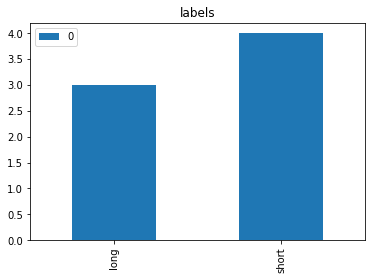

In [ ]:
def check_panda_label_distribution(dict_of_dicts):
#checking distribution of labels in data generated
  list_label = [dict_of_dicts[symbol]['label'] for symbol in  dict_of_dicts]

  counts = Counter(list_label)
  df_counts = pd.DataFrame.from_dict(counts, orient='index')
  df_counts.plot(kind='bar',title='labels')  

#test function
check_panda_label_distribution(test_dict)



check type of elements in each symbol dict (for tfRecord dev)

In [ ]:
def check_types_in_symmbol_dict(symbol_dict):
  for key in symbol_dict:
    print(key, type(symbol_dict[key]))

#test function
random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
test_types = check_types_in_symmbol_dict(random_symbol_dict)

symbol <class 'str'>
end timestamp <class 'pandas._libs.tslibs.timestamps.Timestamp'>
end timestamp_zulu <class 'str'>
panda_present <class 'pandas.core.frame.DataFrame'>
panda_present_first_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
panda_present_last_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
panda_present_last_close <class 'numpy.float64'>
panda_future <class 'pandas.core.frame.DataFrame'>
panda_future_first_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
panda_future_last_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
panda_present_and_future <class 'pandas.core.frame.DataFrame'>
panda_present_and_future_first_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
panda_present_and_future_last_candle <class 'pandas._libs.tslibs.timestamps.Timestamp'>
image <class 'tensorflow.python.framework.ops.EagerTensor'>
label <class 'str'>


# TFrecords writing

Numpy Store TFRecord



In [ ]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
#based on https://www.tensorflow.org/tutorials/load_data/tfrecord
#labels ['short' : 0,'long' : 1,'other' : 2]
int_labels = {
    'short' : 0,
    'long' : 1,
    'other' : 2
}

# Create a dictionary with relevant features
def image_example(image_dict):
  #print(size(image_dict['image']))
  feature = {
      #'height': _int64_feature(size(image_dict['image'])[0]),
      #'width': _int64_feature(size(image_dict['image'])[1]),
      #'depth': _int64_feature(image_dict['image'].shape[2]),
      'symbol': _bytes_feature(image_dict['symbol'].encode('utf-8')),
      'end_timestamp_zulu': _bytes_feature(image_dict['end timestamp_zulu'].encode('utf-8')),
      'label': _int64_feature(int_labels[image_dict['label']]),
      'image': _bytes_feature(image_dict['image']), 
  }
  #print(array_to_img(image_dict['image']))
  #print(array_to_img(image_dict['image']).tobytes())

  return tf.train.Example(features=tf.train.Features(feature=feature))

#test function
random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
for line in str(image_example(random_symbol_dict)).split('\n')[:20]:
  print(line)
print('...')

features {
  feature {
    key: "end_timestamp_zulu"
    value {
      bytes_list {
        value: "2020-04-17T17:01:00Z"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000P\000P\003\001\021\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\0

In [ ]:
# Write the raw image files to `.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
def save_images_tfrecords(dict_of_dicts, record_file):
  #add number of images at the end of filename
  number_images = len(dict_of_dicts)    
  record_file = record_file + '---'+ str(number_images) +'.tfrec'
  
  with tf.io.TFRecordWriter(record_file) as writer:
    for symbol in dict_of_dicts:
      tf_example = image_example(dict_of_dicts[symbol])
      writer.write(tf_example.SerializeToString())
  print(record_file , 'saved')



#test function
#save_folder = '/content/drive/My Drive/Colab Notebooks/alpaca_images/'
save_folder = '/content/drive/My Drive/Colab Notebooks/alpaca_images_dev/'

random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
end_timestamp_zulu = random_symbol_dict['end timestamp_zulu']
filename = end_timestamp_zulu + '.tfrec'
desfile = save_folder + filename
print(desfile)
save_images_tfrecords(test_dict, desfile)

/content/drive/My Drive/Colab Notebooks/alpaca_images_dev/2020-04-17T17:01:00Z.tfrec
/content/drive/My Drive/Colab Notebooks/alpaca_images_dev/2020-04-17T17:01:00Z.tfrec---7.tfrec saved


In [ ]:
#write images into multiple tfrecords files
def save_images_multiple_tfrecords(dict_of_dicts, record_desfile_template, images_per_file):
  list_keys = list(dict_of_dicts.keys())
  random.shuffle(list_keys) #randomize list to avoid to always batch the same symbols together

  chunks = [list_keys[x:x+images_per_file] for x in range(0, len(list_keys), images_per_file)]

  for chunk in chunks:
    dict_chunk = {}
    for symbol in chunk: #create a chunk dict from the full dict
      dict_chunk[symbol] = dict_of_dicts[symbol]
    #adding an index to tfrecord filename
    desfile = record_desfile_template + '_' + str(chunks.index(chunk))
    #writing chunk dict into tfrecord file
    save_images_tfrecords(dict_chunk, desfile)

#TFrecords reading

In [ ]:
def compare_images(img1, img2):
    """Calculate the difference between two images of the same size
    by comparing channel values at the pixel level.
    `delete_diff_file`: removes the diff image after ratio found
    `diff_img_file`: filename to store diff image

    Adapted from Nicolas Hahn:
    https://github.com/nicolashahn/diffimg/blob/master/diffimg/__init__.py
    """

    # Don't compare if images are of different modes or different sizes.
    if (img1.mode != img2.mode) \
            or (img1.size != img2.size) \
            or (img1.getbands() != img2.getbands()):
        return None

    # Generate diff image in memory.
    diff_img = ImageChops.difference(img1, img2)
    # Calculate difference as a ratio.
    stat = ImageStat.Stat(diff_img)
    diff_ratio = sum(stat.mean) / (len(stat.mean) * 255)

    return diff_ratio * 100 

In [ ]:
def _parse_image_function(example_proto):
  # Create a dictionary describing the features.
  image_feature_description = {
      #'height': tf.io.FixedLenFeature([], tf.int64),
      #'width': tf.io.FixedLenFeature([], tf.int64),
      #'depth': tf.io.FixedLenFeature([], tf.int64),
      'symbol': tf.io.FixedLenFeature([], tf.string),
      'end_timestamp_zulu': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.int64),
      'image': tf.io.FixedLenFeature([], tf.string),
  }
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def load_data_from_tfrecord(desfile):
  raw_image_dataset = tf.data.TFRecordDataset(desfile)
  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

  decoded_dict = {}
  for image_features in parsed_image_dataset:
    decoded_symbol_dict={}
    #height = image_features['height'].numpy()
    #width = image_features['width'].numpy()
    #shape = [height,width]
    decoded_image = tf.io.decode_jpeg(image_features['image'])  
    symbol = image_features['symbol'].numpy().decode()
    end_timestamp_zulu = image_features['end_timestamp_zulu'].numpy().decode()

    decoded_symbol_dict['symbol']=symbol
    #decoded_symbol_dict['height']=height
    #decoded_symbol_dict['width']=width
    decoded_symbol_dict['shape']=shape
    decoded_symbol_dict['end_timestamp_zulu']=end_timestamp_zulu
    decoded_symbol_dict['image']=decoded_image
    decoded_dict[symbol] = decoded_symbol_dict
    #print(decoded_dict)
  return decoded_dict

#test function
#test_dict_decoded = load_data_from_tfrecord(desfile)

random_symbol = random.choice(list(test_dict.keys()))
random_symbol_dict = test_dict[random_symbol]
#random_symbol_dict_decoded = test_dict_decoded[random_symbol]
#print('original', random_symbol_dict['symbol'], 'decoded', random_symbol_dict_decoded['symbol'])
#print('original', size(random_symbol_dict['image'])[0], 'decoded', random_symbol_dict_decoded['height'])
#print('original', size(random_symbol_dict['image'])[1], 'decoded', random_symbol_dict_decoded['width'])
#print('original', random_symbol_dict['end timestamp_zulu'], 'decoded', random_symbol_dict_decoded['end_timestamp_zulu'])
#original_random_image = tf.io.decode_jpeg(random_symbol_dict['image'])
#decoded_random_image = random_symbol_dict_decoded['image']
#print('original', original_random_image, 'decoded', decoded_random_image, 'equal images?', compare_images(original_random_image,decoded_random_image))
#display_one_image(decoded_random_image,random_symbol,111,'black')

#building the Alpaca image dataset into frecords files

In [ ]:
def random_open_market_datetimes(start, end, n_dates=10):
  '''
  function to provide a list of random datetimes at the right format for Alpaca (with a Z at then end) when market is open
  '''
  return_datetimes = []
  #print(size(return_datetimes))
  while size(return_datetimes) < n_dates:
    proposed_date = random_datetimes_or_dates(start, end, out_format='datetime', n=1)[0]
    proposed_date_Z = Timestamp_UTC_iso_to_zulu(proposed_date)
    if market_was_open(proposed_date):
      return_datetimes.append(proposed_date)

  
  return return_datetimes

#test 
test_open_datetimes = random_open_market_datetimes(start, end, n_dates=10)
print(test_open_datetimes)

sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 2 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...


[Timestamp('2020-04-20 19:43:27'), Timestamp('2020-04-20 19:22:22'), Timestamp('2020-04-24 17:12:02'), Timestamp('2020-04-22 19:31:36'), Timestamp('2020-04-21 15:00:20'), Timestamp('2020-04-22 15:12:50'), Timestamp('2020-04-20 18:59:04'), Timestamp('2020-04-21 16:55:23'), Timestamp('2020-04-23 17:23:21'), Timestamp('2020-04-22 18:23:21')]


In [ ]:
def main(symbols_list, IMG_SIZE, start, end, n_dates = 1):
  save_folder = '/content/drive/My Drive/Colab Notebooks/Alpaca_5min_ML/20200919_images_5min_size80/'
  #save_folder = '/content/drive/My Drive/Colab Notebooks/alpaca_images_dev/'

  dates = random_open_market_datetimes(start, end, n_dates=n_dates)
  print(dates,'\n')

  i = 0
  for date in dates:
    i = i+1
    date_Z=Timestamp_UTC_iso_to_zulu(date)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','\n','%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%','\n',str(i),'/',str(n_dates),'starting a new datetime dataset preparation', date_Z,'\n')
    data_dict = get_pandas_images_data_for_tradable_assets_images(IMG_SIZE, symbols_list, date, '5Min')

    number_images = len(data_dict)    
    filename = date_Z# + '---'+ str(number_images) +'.tfrec'
    desfile = save_folder + filename
    #save_images_tfrecords(data_dict, desfile)
    save_images_multiple_tfrecords(data_dict, desfile,1000)

#test
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('2020-09-10')
testSymbols = assetSymbolListTradable
#testSymbols = ['BT','FLORIAN','MSFT', 'TSLA', 'CSCO', 'EA', 'BIOC', 'KO', 'DELL', 'NRGD']
test_main = main(testSymbols, IMG_SIZE, start, end, n_dates=400)

  

sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1Min 3 more time(s)...
sleep 3 seconds and retrying htt

[Timestamp('2020-09-02 21:06:40'), Timestamp('2020-02-07 19:58:00'), Timestamp('2020-02-05 16:23:50'), Timestamp('2020-07-27 15:47:00'), Timestamp('2020-04-13 19:52:38'), Timestamp('2020-07-08 16:31:33'), Timestamp('2020-05-14 14:45:33'), Timestamp('2020-01-09 18:28:47'), Timestamp('2020-03-31 16:51:35'), Timestamp('2020-05-18 18:11:56'), Timestamp('2020-08-05 18:27:48'), Timestamp('2020-08-17 17:51:40'), Timestamp('2020-08-20 15:02:41'), Timestamp('2020-04-06 13:32:01'), Timestamp('2020-07-01 14:48:53'), Timestamp('2020-04-14 19:44:44'), Timestamp('2020-01-15 17:40:21'), Timestamp('2020-01-30 17:08:25'), Timestamp('2020-01-10 20:41:39'), Timestamp('2020-07-25 15:17:12'), Timestamp('2020-06-04 14:09:00'), Timestamp('2020-07-27 19:35:34'), Timestamp('2020-05-18 16:27:24'), Timestamp('2020-08-18 13:40:47'), Timestamp('2020-07-01 14:40:22'), Timestamp('2020-03-16 17:50:04'), Timestamp('2020-05-01 14:11:37'), Timestamp('2020-04-07 19:27:55'), Timestamp('2020-02-19 19:16:12'), Timestamp('20


2485 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2981 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2983 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2584 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'AND


2846 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2684 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA'


2813 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


3019 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2869 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


2809 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB',


2557 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'A


2530 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2519 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2861 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


2695 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA'


2843 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


3011 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2987 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


3019 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2593 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'AND


2771 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB',


2582 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'AND


2809 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB',


2528 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2695 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA'


2913 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM


2825 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2858 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


2967 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2837 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2626 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR


2551 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'A


2861 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


2725 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT'


2502 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2827 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2807 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB',


2497 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 


2954 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2956 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2979 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2672 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR


3008 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2824 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2478 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2538 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2924 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AM


2939 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMH


2492 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2944 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H


2731 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL'


2998 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2745 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB', 'AMTI',


2906 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM


2731 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL'


2827 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2971 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2884 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCO', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV'


2987 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2477 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2825 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2827 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2934 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AM


2522 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2859 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


2525 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


2962 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2970 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2627 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR


2478 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2826 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2783 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB',


2866 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB',


3019 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2685 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA'


2839 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


3019 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2913 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM


2634 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR


2947 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


3013 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2745 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 'AMTBB', 'AMTI',


2485 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2524 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', '


3019 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIM', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', '


2494 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIIQ', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMUB', 'AMWL', 'AMYT', 'ANCN', 'ANDA', 'ANDAR', 'ANDAU', 'ANH-A', 'ANH-B', 'ANH-C',


2843 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMS', 


2954 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACU', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEFC', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESE', 'AESR', 'AEY', 'AEYE', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFINP', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGNCM', 'AGNCO', 'AGNCP', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHCO', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIKI', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALRS', 'ALTA', 'ALTG', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'ALYA', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G',


2702 symbols have been deleted out of 8830 because of empty or too short panda, for ['AACG', 'AAME', 'ACES', 'ACEVU', 'ACND.U', 'ACSG', 'ACSI', 'ACY', 'ADCT', 'ADFI', 'ADME', 'ADTX', 'ADXN', 'AEL-A', 'AEL-B', 'AEP-B', 'AEP-C', 'AESR', 'AFC', 'AFGB', 'AFGC', 'AFGD', 'AFIB', 'AFIF', 'AFLG', 'AFMC', 'AFSM', 'AGBA', 'AGBAR', 'AGBAU', 'AGM-A', 'AGM-C', 'AGM-D', 'AGM-E', 'AGM-F', 'AGM.A', 'AGO-B', 'AGO-E', 'AGO-F', 'AGT', 'AHH-A', 'AHL-C', 'AHL-D', 'AHL-E', 'AHT-D', 'AHT-F', 'AHT-G', 'AHT-H', 'AHT-I', 'AI-B', 'AI-C', 'AIC', 'AIG-A', 'AIH', 'AIIQ', 'AIO', 'AIRT', 'AIRTP', 'AIW', 'BIVI', 'U', 'AIZP', 'AJXA', 'AKO.A', 'AKU', 'AKUS', 'AL-A', 'ALAC', 'ALACR', 'ALACU', 'ALIN-A', 'ALIN-B', 'ALIN-E', 'ALL-B', 'ALL-G', 'ALL-H', 'ALL-I', 'ALLY-A', 'ALP-Q', 'ALTA', 'ALTL', 'ALTS', 'ALTY', 'ALUS', 'ALUS.U', 'ALVR', 'ALXO', 'AMBO', 'AMCA', 'AMCI', 'AMCIU', 'AMH-D', 'AMH-E', 'AMH-F', 'AMH-G', 'AMH-H', 'AMHC', 'AMHCU', 'AMNA', 'AMND', 'AMOM', 'AMOV', 'AMRB', 'AMTBB', 'AMTI', 'AMUB', 'AMWL', 'AMYT', 'ANCN'

KeyboardInterrupt: ignored